<h1> My Construction Story by Maxwell Grant </h1>

<h3> Annotated Time Series Graph </h3>

<h4> Database: DOB Permit Issuance </h4>

Link: https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a

In [1]:
import pandas as pd
from sodapy import Socrata
import datetime
import matplotlib.pyplot as plt
import seaborn

Create a company dictionary with company names and license numbers.

In [2]:
companyDict = {'accuraInc': '0008711', 'accuraLLC': '0612416', 'skyline': '0003365', 'pofi': '0609000'}

Access the dataset via SODA API. The database has over 3.7M rows. To query, we will use SoQL. The WHERE clause will get the instances of the licenses we want. Load the query into a data frame. Optional: insert an application token to remove the warning message with an account at NYC Open Data.

In [3]:
data_url= 'data.cityofnewyork.us' 
dataset='ipu4-2q9a'    
app_token= None 
client = Socrata(data_url,app_token)  
client.timeout = 60
where_clause = f'''
permittee_s_license__ = '{companyDict['accuraInc']}'
OR permittee_s_license__ = '{companyDict['accuraLLC']}'
OR permittee_s_license__ = '{companyDict['skyline']}'
OR permittee_s_license__ = '{companyDict['pofi']}'
'''
results = client.get(dataset, where=where_clause, limit=7000)
df = pd.DataFrame.from_records(results)

The API call is now in a Python Pandas data frame.

Uncomment the cells below to view a list of column headers and unique business names from the data frame.

In [4]:
#df.columns.values

In [5]:
uniqueList = df['permittee_s_business_name'].unique()
#uniqueList

Remove three business names from the dataframe that may be data entry errors.

In [6]:
df = df[(df['permittee_s_business_name'] != 'ROCKLEDGE SCAFFOLD') & 
        (df['permittee_s_business_name'] != 'DJM CONTR. SERVICES, CORP.') &
        (df['permittee_s_business_name'] != 'CENTERLINE DISTRIBUTORS INC')]

Filter out minor project types. The major projects these companies undertake are exterior masonry projects. We can define those permits with the permit codes OT and EW. OT is Other Trade and EW is Exterior Work.

In [7]:
df = df[(df['work_type'] == 'OT') & (df['permit_type'] == 'EW')]

Prepare the date data by converting issuance_date to a datetime datatype.

In [8]:
df['issuance_date'] = pd.to_datetime(df['issuance_date']) 

Add an array of each permit's first and last year to the company dictionary.

In [9]:
for company in companyDict.keys():
    list1 = []
    list1.append(companyDict.get(company))
    minYear = df['issuance_date'][df['permittee_s_license__'] == companyDict.get(company)].min().year
    maxYear = df['issuance_date'][df['permittee_s_license__'] == companyDict.get(company)].max().year
    list1.append(minYear)
    list1.append(maxYear)
    companyDict[company] = list1    

In [10]:
companyDict

{'accuraInc': ['0008711', 1998, 2017],
 'accuraLLC': ['0612416', 2014, 2022],
 'skyline': ['0003365', 1997, 2023],
 'pofi': ['0609000', 2012, 2022]}

Create dictionaries of unique permit counts per year for the time series graph y-variables. We use the .unique() method because project permits are renewed multiple times a year. This will ensure every project is counted only once a year.

In [11]:
for company in companyDict.keys():
    globals()[company] = dict()
    for year in range(companyDict.get(company)[1], companyDict.get(company)[2]+1):
        start = datetime.datetime(year, 1, 1)
        end = datetime.datetime(year, 12, 31)
        df2 = df[(df['issuance_date'] >= start) & (df['issuance_date'] <= end) & (df['permittee_s_license__'] == companyDict.get(company)[0])]
        uniqueJobs = len(df2['job__'].unique())
        globals()[company][year] = uniqueJobs

Create a new data frame from the dictionaries created in the cell above. The data frame is prepared for plotting and the .max() year is 2022 because 2021 was the last year I worked in NYC's Local Law 11 industry.

In [12]:
companies = [company for company in companyDict.keys()]
dfPlot = pd.DataFrame([accuraInc, accuraLLC, skyline, pofi], index=companies)
dfPlot = dfPlot.transpose()
dfPlot = dfPlot.sort_index()
dfPlot.reset_index(inplace=True)
dfPlot = dfPlot.rename(columns = {'index':'year'})
dfPlot['year'] = pd.to_datetime(dfPlot['year'], format='%Y')
endYear = datetime.datetime(2022, 1, 1)
dfPlot = dfPlot[dfPlot['year'] <= endYear]

The time series graph below illustrates the three companies I worked for. Starting in 2008, I interned for the summers at Accura Restoration. In 2012, I started my full-time position after graduating from SUNY Cortland with a BS in Business Economics. After two years, Accura Restoration decided to merge with Skyline Restoration. A new LLC company/license was created and the Inc license finished their ongoing projects. I was moved to Andromeda Advantage which managed both Accura Restoration and Skyline Restoration.  In 2020, I was offered an opportunity to project manage at Pofi Construction which was a young and fast-growing company while I pursued an EMS in Information Systems with a concentration in Data Analytics at The Zicklin School of Business. After graduating, I switched careers to data analytics with an opportunity in utility management.

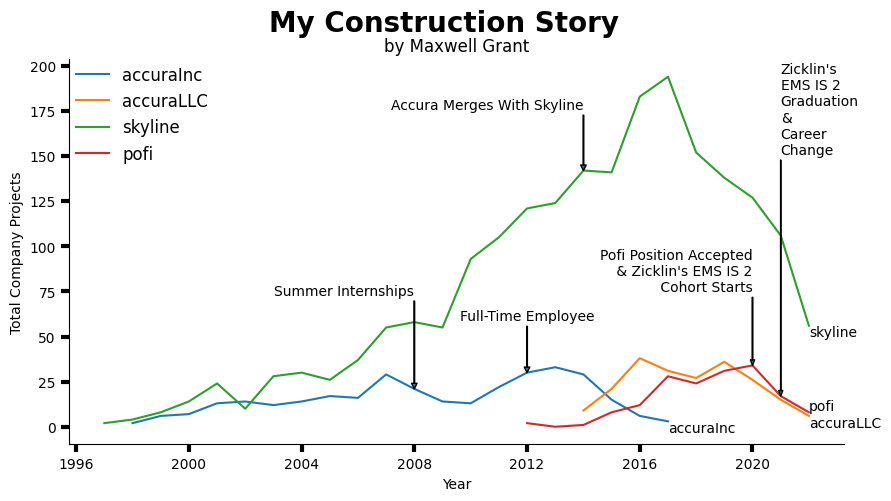

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches([10,5])
ax.plot(dfPlot['year'], dfPlot[companies])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(direction='out', length = 6, width = 3)
ax.set_xlabel('Year')
ax.set_ylabel('Total Company Projects')
fig.suptitle('My Construction Story', fontweight="bold", size = 20)
ax.set_title('by Maxwell Grant')

for company in companies:
    if company != 'accuraInc':
        value = dfPlot[company][dfPlot['year'] == endYear]
        if company == 'pofi':
            value += 7
        ax.annotate(company, xy=(endYear, value), horizontalalignment='left', verticalalignment='top')
    else:
        value = dfPlot[company][dfPlot['year'] == datetime.datetime(2017, 1, 1)]
        ax.annotate(company, xy=(datetime.datetime(2017, 1, 1), value), horizontalalignment='left', verticalalignment='top')

msg = 'Summer Internships'
date = datetime.datetime(2008, 1, 1)
value = dfPlot['accuraInc'][dfPlot['year'] == date]
ax.annotate(msg, xy=(date, value), xytext = (date, value+58),
               arrowprops=dict(headwidth = 4, width = .5, headlength = 4),
               horizontalalignment = 'right', verticalalignment = 'top')

msg = 'Full-Time Employee'
date = datetime.datetime(2012, 1, 1)
value = dfPlot['accuraInc'][dfPlot['year'] == date]
ax.annotate(msg, xy=(date, value), xytext = (date, value+35),
               arrowprops=dict(headwidth = 4, width = .5, headlength = 4),
               horizontalalignment = 'center', verticalalignment = 'top')

msg = 'Accura Merges With Skyline'
date = datetime.datetime(2014, 1, 1)
value = dfPlot['skyline'][dfPlot['year'] == date]
ax.annotate(msg, xy = (date, value), xytext = (date, value+40),
               arrowprops=dict(headwidth = 4, width = .5, headlength = 4),
               horizontalalignment = 'right', verticalalignment = 'top')

msg = "Pofi Position Accepted\n & Zicklin's EMS IS 2\n Cohort Starts"
date = datetime.datetime(2020, 1, 1)
value = dfPlot['pofi'][dfPlot['year'] == date]
ax.annotate(msg, xy=(date, value), xytext = (date, value+65),
               arrowprops=dict(headwidth = 3, width = .5, headlength = 4),
               horizontalalignment = 'right', verticalalignment = 'top')

msg = "Zicklin's\nEMS IS 2\nGraduation\n&\nCareer\nChange"
date = datetime.datetime(2021, 1, 1)
value = dfPlot['pofi'][dfPlot['year'] == date]
ax.annotate(msg, xy=(date, value), xytext = (date, value+185),
               arrowprops=dict(headwidth = 3, width = .25, headlength = 4),
               horizontalalignment = 'left', verticalalignment = 'top')
        
ax.legend(companies, borderaxespad = 0, fontsize = 'large', ncol = 1, frameon = False)

plt.show()